In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import openpyxl
import re
import os
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = r'C:\Users\stephenl\OneDrive - GC International AG\ML\openOrders\data_input\\'
path_output = r'C:\Users\stephenl\OneDrive - GC International AG\ML\openOrders\data_output\\'

In [3]:
# functions

def diff(start, end):
    x = pd.to_datetime(end) - pd.to_datetime(start)
    return int(x / np.timedelta64(1, 'D'))

In [4]:
# list all files in input folder
list1 = os.listdir(path)

In [5]:
# list all files in input folder
list1 = os.listdir(path)

# read the files and concatenate them
tot=pd.DataFrame()
for i in list1:
    f, e = os.path.splitext(i)
    d = re.findall(r'\d{2}\w{5}',f)
    d = ','.join(d)
    x=pd.read_excel(path+i)
    x['read_date']=d
    tot=pd.concat([tot,x])
    
tot.columns = tot.columns.str.lower()
tot.columns = [f.replace(' ','_') for f in tot.columns]

In [6]:
# change date to datetime format
tot.read_date = pd.to_datetime(tot.read_date,format="%d%b%y")
# tot.document_date = pd.to_datetime(tot.document_date,format="%Y-%m-%d")

In [7]:
tot = tot.reset_index(drop=True)

In [8]:
# extract those rows who document numbers starts with 'F'
tot['status']=np.nan
for i,p in zip(tot.index,tot.document_number):
    if re.search(r'^F',p):
        tot.loc[i,'status']='y'
    else:
        tot.loc[i,'status']='n'
        
tot=tot[tot.status=='y']
del tot['status']

In [9]:
tot.columns

Index(['document_type', 'document_number', 'item_number', 'item_description',
       'qty_to_back_order', 'unit_price', 'customer_number', 'customer_name',
       'site_id', 'document_date', 'read_date'],
      dtype='object')

In [10]:
tot.document_date = [i.strftime("%Y/%m/%d") for i in tot.document_date]

In [11]:
tot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4288 entries, 253 to 9102
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   document_type      4288 non-null   object        
 1   document_number    4288 non-null   object        
 2   item_number        4288 non-null   object        
 3   item_description   4288 non-null   object        
 4   qty_to_back_order  4288 non-null   int64         
 5   unit_price         4288 non-null   float64       
 6   customer_number    4288 non-null   object        
 7   customer_name      4288 non-null   object        
 8   site_id            4288 non-null   object        
 9   document_date      4288 non-null   object        
 10  read_date          4288 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 402.0+ KB


In [12]:
# list unique document number and assign to orderNo
orderNo = tot.document_number.unique()

In [13]:
orderNo

array(['F008', 'F010', 'F017', 'F018', 'F021', 'F024', 'F034', 'F037',
       'F039', 'F040', 'F043', 'F046', 'F049', 'F050', 'F058', 'F069',
       'F070', 'F071', 'F072', 'F074', 'F075', 'F077', 'F082', 'F086',
       'F092', 'F093', 'F096', 'F096A', 'F097', 'F098', 'F099', 'F100',
       'F100A', 'F104', 'F104A', 'F106', 'F107', 'F108', 'F108A', 'F109',
       'F109A', 'F113', 'F114', 'F116', 'F122DG', 'F124', 'F125', 'F126.',
       'F129', 'F130', 'F131', 'F132.', 'F134', 'F135', 'F136', 'F137',
       'F138', 'F141', 'F142', 'F143', 'F146', 'F150', 'F159A', 'F159B',
       'F160', 'F161', 'F162', 'F163', 'F165', 'F166', 'F173', 'F175',
       'F176', 'F177', 'F187', 'F189', 'F195', 'F201', 'F201SR', 'F202',
       'F203MI', 'F205', 'F205DG', 'F206', 'F207', 'F208', 'F209', 'F211',
       'F212', 'F222', 'F005', 'F006', 'F020', 'F027', 'F046SOLARE',
       'F052', 'F053', 'F073', 'F112', 'F001', 'F003', 'F015', 'F076',
       'F083', 'F098A', 'F111A', 'F122B', 'F045', 'F022', 'F02

In [14]:
final=pd.DataFrame(columns=['order','end_date','performance_rate'])

In [15]:

for e,i in enumerate(orderNo):
    # extract df according to orderNo
    x = tot[tot.document_number==i]
    x = x.reset_index(drop=True)
    # extract start and end of read date
    start=x.read_date.min()
    end = x.read_date.max()
    # extract no of week between start and end of read date
    timeDiff = diff(start,end)
    # extract df or start read date and end read date
    Sdate = x[x.read_date==start]
    Edate = x[x.read_date==end]
    # extract total back order qty of start date and end date
    SdateQty = Sdate.qty_to_back_order.sum()
    EdateQty = Edate.qty_to_back_order.sum()
    rate = abs((EdateQty-SdateQty)/SdateQty)/timeDiff
    final.loc[e,'order']=i
#     final.loc[e,'date_created']=x.loc[0,'document_date']
    final.loc[e,'end_date']=end
    final.loc[e,'performance_rate']=rate

In [16]:
final['date_dt'] = pd.DatetimeIndex(final.end_date).to_period("M")

In [17]:
final

,order,end_date,performance_rate,date_dt
0,F008,2022-09-07 00:00:00,0.011686,2022-09
1,F010,2022-09-07 00:00:00,0.002374,2022-09
2,F017,2022-09-07 00:00:00,0.008747,2022-09
3,F018,2022-09-19 00:00:00,0.007724,2022-09
4,F021,2022-09-19 00:00:00,0.0,2022-09
5,F024,2022-09-19 00:00:00,0.002667,2022-09
6,F034,2022-09-07 00:00:00,0.008667,2022-09
7,F037,2022-09-07 00:00:00,0.0059,2022-09
8,F039,2022-09-19 00:00:00,0.0,2022-09
9,F040,2022-09-19 00:00:00,0.0,2022-09


In [18]:
final = final.dropna()

In [19]:
final_gby = final.groupby(['date_dt']).agg(ave_performance=('performance_rate','mean')).reset_index()

In [20]:
final_gby.sort_values('date_dt')

,date_dt,ave_performance
0,2022-05,0.000000
1,2022-06,0.000000
2,2022-07,0.003765
3,2022-08,0.009137
4,2022-09,0.006241


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

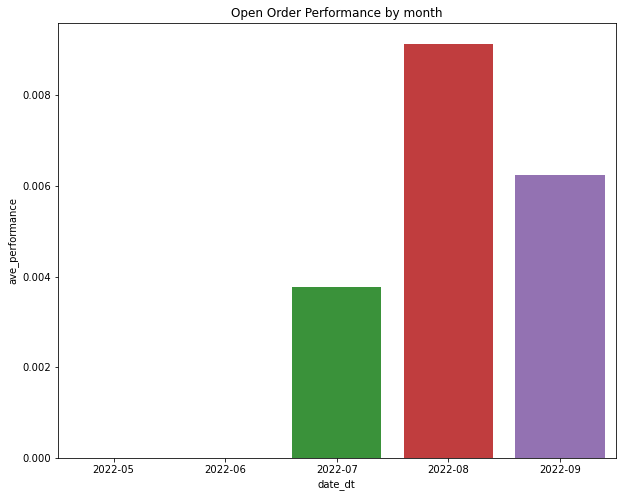

In [22]:
plt.figure(figsize=(10,8))
sns.barplot(data=final_gby, x='date_dt',y='ave_performance')
plt.title("Open Order Performance by month")
plt.show()

In [23]:
final_gby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   date_dt          5 non-null      period[M]
 1   ave_performance  5 non-null      float64  
dtypes: float64(1), period[M](1)
memory usage: 208.0 bytes


In [24]:
tot

,document_type,document_number,item_number,item_description,qty_to_back_order,unit_price,customer_number,customer_name,site_id,document_date,read_date
253,Order,F008,0104B406-0000,Pattern Resin 1-1 Package (DG),100,60.00,D153S,LIEN NHA CO LTD,GCW,2022/07/26,2022-09-07
254,Order,F010,900834,everStick C&B 1 x 8 cm (CR),30,66.60,D029S,BUMI MED RESOURCES,GCW,2022/04/08,2022-09-07
255,Order,F017,137206,Examix Heavy NDS 2-Cartridge Pkg,1,35.80,D024S,KALDERA SDN BHD,GCW,2022/04/20,2022-09-07
256,Order,F018,0127F072-0020,Unifast III Powder 100g A2,1,91.10,D018S,QUANTUMLEAP HEALTHCARE PTE LTD,GCW,2022/04/28,2022-09-07
257,Order,F021,0137F095-0000,Solare Universal Bond 2.5ml (DG) (CR),240,24.40,D057S,DENTAL DOMAIN CORPORATION,GCW,2022/04/21,2022-09-07
258,Order,F021,0137F095-0000,Solare Universal Bond 2.5ml (DG) (CR) (PROMO),120,0.00,D057S,DENTAL DOMAIN CORPORATION,GCW,2022/04/21,2022-09-07
259,Order,F024,0101B677-0230,Fuji II LC Caps Box of 50 # B3,2,149.30,D082S,PHARMAFORTE SINGAPORE PTE LTD,GCW,2022/04/22,2022-09-07
260,Order,F034,0138F119-0110,G-aenial Universal Injectable 1.7g AO2,20,34.00,D037S,PT ANUGERAH PHARMINDO LESTARI (PROMED),GCW,2022/05/13,2022-09-07
261,Order,F037,900832,everStick PERIO 1 x 8 cm (CR),10,64.60,D037S,PT ANUGERAH PHARMINDO LESTARI (PROMED),GCW,2022/05/13,2022-09-07
262,Order,F039,0138F286-0020,GC Gold Label IX EXTRA CAPSULE A3,400,62.50,D037S,PT ANUGERAH PHARMINDO LESTARI (PROMED),GCW,2022/08/11,2022-09-07


In [25]:
itemNo = tot.item_number.unique()

In [26]:
final_item=pd.DataFrame(columns=['item_no','end_date','performance_rate'])

for e,i in enumerate(itemNo):
    # extract df according to orderNo
    x = tot[tot.item_number==i]
    x = x.reset_index(drop=True)
    # extract start and end of read date
    start=x.read_date.min()
    end = x.read_date.max()
    # extract no of week between start and end of read date
    timeDiff = diff(start,end)
    # extract df or start read date and end read date
    Sdate = x[x.read_date==start]
    Edate = x[x.read_date==end]
    # extract total back order qty of start date and end date
    SdateQty = Sdate.qty_to_back_order.sum()
    EdateQty = Edate.qty_to_back_order.sum()
    rate = abs((EdateQty-SdateQty)/SdateQty)/timeDiff
    final_item.loc[e,'item_no']=i
#     final_item.loc[e,'date_created']=x.loc[0,'document_date']
    final_item.loc[e,'end_date']=end
    final_item.loc[e,'performance_rate']=rate

In [27]:
final_item

,item_no,end_date,performance_rate
0,0104B406-0000,2022-09-19 00:00:00,0.113095
1,900834,2022-09-19 00:00:00,0.024222
2,137206,2022-09-19 00:00:00,0.00425
3,0127F072-0020,2022-09-19 00:00:00,0.002
4,0137F095-0000,2022-09-19 00:00:00,0.0
5,0101B677-0230,2022-09-19 00:00:00,0.004
6,0138F119-0110,2022-09-19 00:00:00,0.004082
7,900832,2022-09-19 00:00:00,0.0368
8,0138F286-0020,2022-09-19 00:00:00,0.581067
9,0130F078-0040,2022-09-19 00:00:00,0.072789


In [28]:
final_item = final_item.sort_values('performance_rate',ascending=False)
final_item = final_item.dropna()
final_item20 = final_item.head(20)
final_item20.performance_rate = [i.round(2) for i in final_item20.performance_rate]

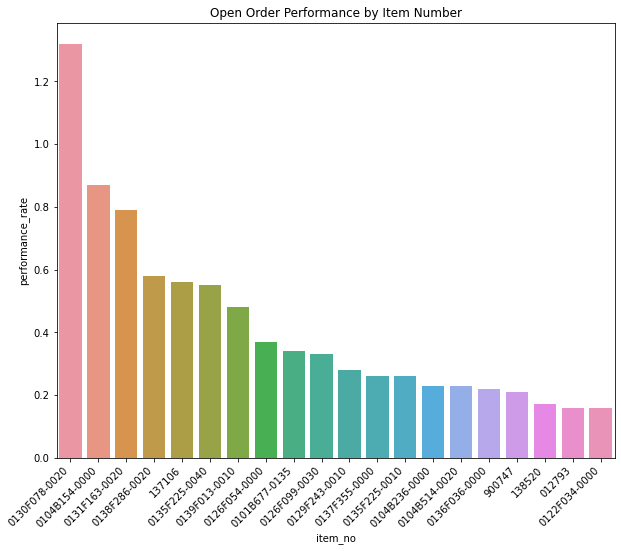

In [29]:
plt.figure(figsize=(10,8))
chart = sns.barplot(data=final_item20, x='item_no', y='performance_rate')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Open Order Performance by Item Number")
plt.show()